# How to create metrics from your model

In [1]:
from spectroscopy import PLSEstimator, Metrics
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error)
import pandas as pd

%load_ext autoreload
%autoreload 2

First lets train and fit a model using the PLS estimator.

This first routine loops through y_test columns (recall that y_test is stored as a dataframe attribute in the PLS class) and calculates the R2 score for each, against the corresponding target variables, held in y_pred as a 2-dimensional array. Given the output is another array of unmarked indices, we load to a dataframe with corresponding element names. We create a multilevel index using the leaf_state and season together with the elements so that the dataframe can be extended to accommodate more tests.


------- Loading data -------
Loading data for dataset ( DRIED | 2 )
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 144 samples.

------- Partition data -------
Train set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.

Test set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.
Now partitioning features and targets for train data...
X and y have shapes (115, 4200), (115, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.
Now partitioning features and targets for test data...
X and y have shapes (29, 4200), (29, 13):

------- Finding best parameter -------
Comparing train and test features...
Comparing train and test targets..

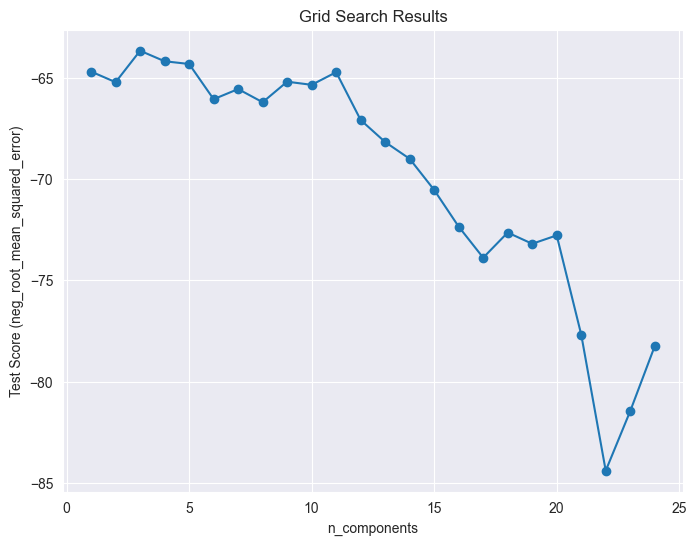


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.


In [2]:
def run_pls(leaf_state, season):
    pls = PLSEstimator()
    pls.load_dataset(leaf_state, season)
    pls.partition(test_size=0.2)
    pls.preprocess("train", 0.5, 0.5, 0.5, impute_target_method="knn", impute_feature_method="neighbour_avg")
    pls.preprocess("test", 0.5, 1.1, 0.2, impute_target_method=None, impute_feature_method="neighbour_avg")
    pls.find_component()
    pls.fit_predict()
    return pls

pls = run_pls("DRIED",2)

In [3]:
# Initialise the results dataframe first, such that it can be successfully used in concat without deprecation error
index_names = ['leaf_state', 'season', 'target']
empty_index = pd.MultiIndex.from_tuples([], names=index_names)
column_types = {'r2': float, 'mse': float, 'rmse': float, 'mae': float, 'mape': float}
results_df = pd.DataFrame(index=empty_index, columns=column_types.keys()).astype(column_types)

In [4]:
results_df = pd.DataFrame()
r2_scores = []
for i in range(pls.y_test.shape[1]):
    r2 = r2_score(pls.y_test.iloc[:, i], pls.y_pred[:, i])
    r2_scores.append(r2)
index = pd.MultiIndex.from_product([[pls.leaf_state],[pls.season],pls.y_test.columns], names=['leaf_state','season','target'])
r2_df = pd.DataFrame(data=r2_scores, index=index, columns=["r2"])
results_df = pd.concat([results_df,r2_df])
results_df


r2
leaf_state season target          
DRIED      2      Al      0.589266
                  B       0.607453
                  Ca      0.164312
                  Cu      0.100787
                  Fe      0.193593
                  Mg      0.413447
                  Mn      0.189100
                  N       0.686910
                  P       0.510064
                  K       0.355386
                  Na      0.544184
                  S       0.451263
                  Zn      0.268610

Now we'll append another metric, mean squared error to the dataframe.

In [5]:
def extend_index(idx: pd.DataFrame.index, leaf_state: object, season: int, targets: list):
    new_idx = pd.MultiIndex.from_product([[leaf_state],[season],targets], names=['leaf_state','season','target'])
    return idx.union(new_idx)

def fill_metrics(df: pd.DataFrame, scores: list, leaf_state: object, season: int, targets: list, metric: object):
    for i,t in enumerate(targets):
        df.loc[(leaf_state, season, targets[i]), metric] = scores[i]
    return df

def calc_metric(metric, y_test, y_pred):
    if metric == "r2":
        calc_func = r2_score
    elif metric == "mse":
        calc_func = mean_squared_error
    elif metric == "rmse":
        calc_func = root_mean_squared_error
    elif metric == "mae":
        calc_func = mean_absolute_error
    elif metric == "mape":
        calc_func = mean_absolute_percentage_error

    scores = []
    for i in range(y_test.shape[1]):
        score = calc_func(y_test.iloc[:, i], y_pred[:, i])
        scores.append(score)

    return scores

In [6]:
mse_scores = calc_metric("mse", pls.y_test, pls.y_pred)
# for i in range(pls.y_test.shape[1]):
#     mse = mean_squared_error(pls.y_test.iloc[:, i], pls.y_pred[:, i])
#     mse_scores.append(mse)

# Add values for new metric for the same indices
results_df = fill_metrics(results_df, mse_scores, pls.leaf_state, pls.season, pls.y_test.columns, "mse")

results_df

r2           mse
leaf_state season target                        
DRIED      2      Al      0.589266  18479.401492
                  B       0.607453    628.573857
                  Ca      0.164312      0.298594
                  Cu      0.100787     28.458342
                  Fe      0.193593  31835.697816
                  Mg      0.413447      0.127588
                  Mn      0.189100  51603.882835
                  N       0.686910      0.250663
                  P       0.510064      0.002933
                  K       0.355386      3.651254
                  Na      0.544184      0.000106
                  S       0.451263      0.000670
                  Zn      0.268610    329.532673

And now repeat but with a different dataset so that we further populate our results dataframe. Using a function to extend the index deals with problems in concatenating along both axes.


------- Loading data -------
Loading data for dataset ( DRIED | 3 )
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 117 samples.

------- Partition data -------
Train set composition:
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 93 samples.

Test set composition:
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 24 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 76 samples.
Now partitioning features and targets for train data...
X and y have shapes (76, 2101), (76, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 22 samples.
Now partitioning features and targets for test data...
X and y have shapes (22, 2101), (22, 13):

------- Finding best parameter -------
Comparing train and test features...
Comparing train and test targets...
Fi

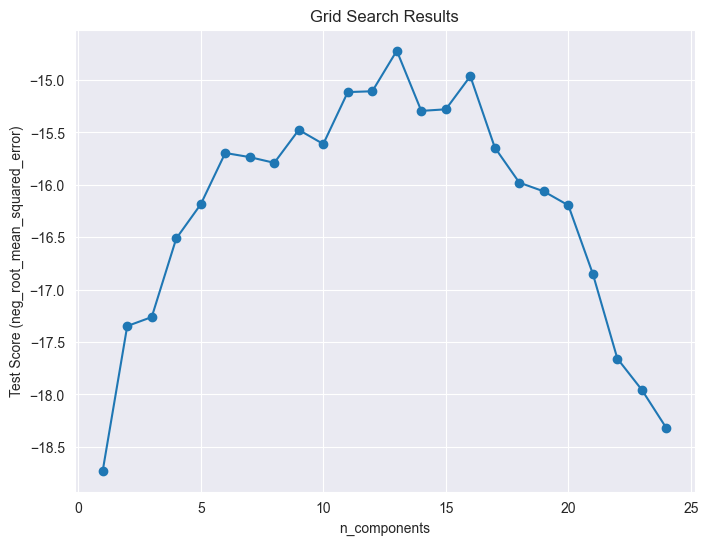


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.


r2           mse
leaf_state season target                        
DRIED      2      Al      0.589266  18479.401492
                  B       0.607453    628.573857
                  Ca      0.164312      0.298594
                  Cu      0.100787     28.458342
                  Fe      0.193593  31835.697816
                  K       0.355386      3.651254
                  Mg      0.413447      0.127588
                  Mn      0.189100  51603.882835
                  N       0.686910      0.250663
                  Na      0.544184      0.000106
                  P       0.510064      0.002933
                  S       0.451263      0.000670
                  Zn      0.268610    329.532673
           3      Al     -0.029073   1075.567375
                  B      -0.939711     35.104810
                  Ca      0.440215      0.105853
                  Cu     -1.039078     63.674724
                  Fe     -0.111530   2285.407342
                  K       0.513385      1.721415
                  Mg      0.616157      0.028026
                  Mn     -0.530943  18515.679738
                  N       0.791326      0.087199
                  Na      0.123971      0.000017
                  P       0.614958      0.001672
                  S       0.096972      0.001223
                  Zn      0.000698    490.144371

In [7]:
# Fit new dataset
pls = run_pls("DRIED",3)

# Extend index
results_df = results_df.reindex(extend_index(results_df.index, pls.leaf_state, pls.season, pls.y_test.columns))

r2_scores = calc_metric("r2", pls.y_test, pls.y_pred)
results_df = fill_metrics(results_df, r2_scores, pls.leaf_state, pls.season, pls.y_test.columns, "r2")

mse_scores = calc_metric("mse", pls.y_test, pls.y_pred)
results_df = fill_metrics(results_df, mse_scores, pls.leaf_state, pls.season, pls.y_test.columns, "mse")

results_df


Now, we put the above functions into a class and can run through all datasets and populate the scores, to then look to form some sort of aggregation over the scores. The following test the concept of creating a set of scores for one dataset and adding another. First, lets predict on more than one dataset.


------- Loading data -------
Loading data for dataset ( DRIED | 1 )
Data comprises of {1} seasons, and {'DRIED'} sample modes.
Dataset has 40 samples.

------- Partition data -------
Train set composition:
Data comprises of {1} seasons, and {'DRIED'} sample modes.
Dataset has 32 samples.

Test set composition:
Data comprises of {1} seasons, and {'DRIED'} sample modes.
Dataset has 8 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {1} seasons, and {'DRIED'} sample modes.
Dataset has 31 samples.
Now partitioning features and targets for train data...
X and y have shapes (31, 4200), (31, 14):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {1} seasons, and {'DRIED'} sample modes.
Dataset has 8 samples.
Now partitioning features and targets for test data...
X and y have shapes (8, 4200), (8, 14):

------- Finding best parameter -------
Comparing train and test features...
Comparing train and test targets...
Fitting

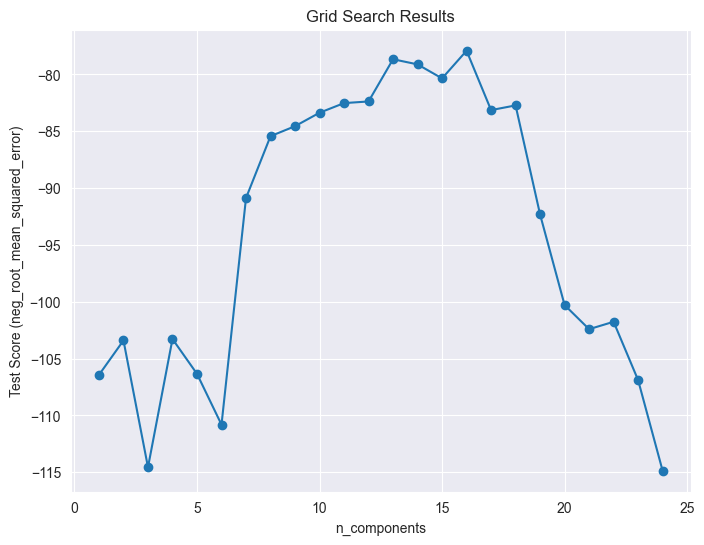


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.

------- Loading data -------
Loading data for dataset ( DRIED | 2 )
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 144 samples.

------- Partition data -------
Train set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.

Test set composition:
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 115 samples.
Now partitioning features and targets for train data...
X and y have shapes (115, 4200), (115, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {2} seasons, and {'DRIED'} sample modes.
Dataset has 29 samples.
Now partitioning features and targets for test d

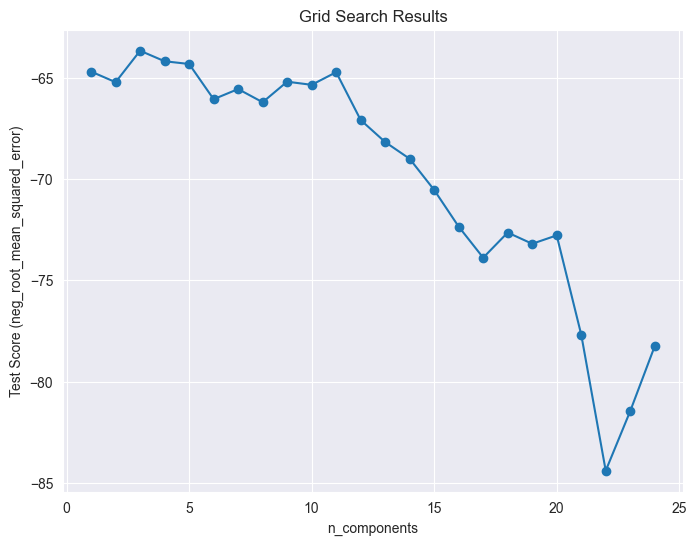


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.

------- Loading data -------
Loading data for dataset ( DRIED | 3 )
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 117 samples.

------- Partition data -------
Train set composition:
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 93 samples.

Test set composition:
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 24 samples.

------- Preprocessing data -------
Preprocessing train data...
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 76 samples.
Now partitioning features and targets for train data...
X and y have shapes (76, 2101), (76, 13):

------- Preprocessing data -------
Preprocessing test data...
Data comprises of {3} seasons, and {'DRIED'} sample modes.
Dataset has 22 samples.
Now partitioning features and targets for test data.

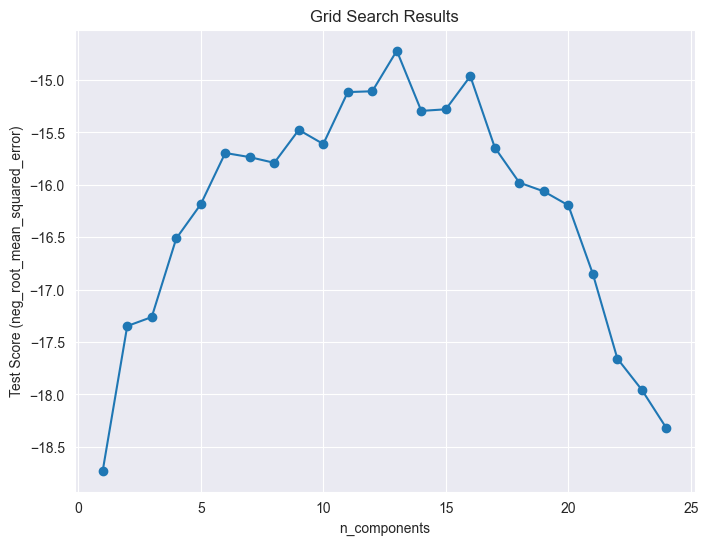


------- Learning, prediction and evaluation -------
Comparing train and test features...
Comparing train and test targets...
Training and prediction complete.


In [8]:
pls1 = run_pls("DRIED",1)
pls2 = run_pls("DRIED",2)
pls3 = run_pls("DRIED",3)

In [9]:
from spectroscopy.src.metrics import Metrics

Now, we check that calculation one set (by instantiating the class) is okay.

In [13]:
metrics1 = Metrics(pls1.y_pred, pls1.y_test, pls1.leaf_state, pls1.season)
metrics1.results.head()

r2           mse        rmse     rrmse  \
leaf_state season target                                                 
DRIED      1      Al      0.923330  44496.890568  210.942861  0.182068   
                  B       0.141976      9.853866    3.139087  0.030303   
                  Ca      0.827843      0.022998    0.151650  0.034619   
                  Cl      0.653843      0.199206    0.446325  0.092835   
                  Cu     -1.611555     37.173853    6.097036  0.325378   

                                 mae      mape  
leaf_state season target                        
DRIED      1      Al      141.870954  0.941836  
                  B         2.536494  0.068246  
                  Ca        0.122402  0.090585  
                  Cl        0.384607  0.195935  
                  Cu        3.702747  0.691574

Now we add a separate dataset, and that proves okay.

In [14]:
metrics1.add_dataset(pls2.y_pred, pls2.y_test, pls2.leaf_state, pls2.season)
metrics1.results.head()

r2           mse        rmse     rrmse  \
leaf_state season target                                                 
DRIED      1      Al      0.923330  44496.890568  210.942861  0.182068   
                  B       0.141976      9.853866    3.139087  0.030303   
                  Ca      0.827843      0.022998    0.151650  0.034619   
                  Cl      0.653843      0.199206    0.446325  0.092835   
                  Cu     -1.611555     37.173853    6.097036  0.325378   

                                 mae      mape  
leaf_state season target                        
DRIED      1      Al      141.870954  0.941836  
                  B         2.536494  0.068246  
                  Ca        0.122402  0.090585  
                  Cl        0.384607  0.195935  
                  Cu        3.702747  0.691574

Now we want to make sure that we can produce results on an amalgamated dataset - therefore not being concerned with categorising the results by leaf_state or season.

In [15]:
metrics2 = Metrics(pls1.y_pred, pls1.y_test) # Omit leaf_state and season parameters
metrics2.results.head()

,r2,mse,rmse,rrmse,mae,mape
target,,,,,,
Al,0.923330,44496.890568,210.942861,0.182068,141.870954,0.941836
B,0.141976,9.853866,3.139087,0.030303,2.536494,0.068246
Ca,0.827843,0.022998,0.151650,0.034619,0.122402,0.090585
Cl,0.653843,0.199206,0.446325,0.092835,0.384607,0.195935
Cu,-1.611555,37.173853,6.097036,0.325378,3.702747,0.691574


In [16]:
# Check aggregation for multi-level index
metrics1.aggregate(['leaf_state','season'])

r2           mse       rmse     rrmse        mae  \
leaf_state season                                                           
DRIED      1       0.010181  18512.804077  65.789977  0.157642  47.189710   
           2       0.390336   7916.144525  45.653381  0.078472  34.826746   

                       mape  
leaf_state season            
DRIED      1       0.487007  
           2       0.454705

In [17]:
# Check aggregation for single level (target only) index
metrics1.aggregate(["target"])

,r2,mse,rmse,rrmse,mae,mape
target,,,,,,
Al,0.756298,31488.146030,173.440912,0.153656,117.009998,0.937852
B,0.374715,319.213861,14.105231,0.060458,8.672330,0.158055
Ca,0.496078,0.160796,0.349044,0.046002,0.262767,0.153972
Cl,0.653843,0.199206,0.446325,0.092835,0.384607,0.195935
Cu,-0.755384,32.816097,5.715836,0.226814,3.723273,0.752482
Fe,0.533923,88019.166755,279.082915,0.205883,192.270985,1.181155
K,0.564866,2.270632,1.427114,0.049906,1.211876,0.213159
Mg,0.588194,0.074894,0.253094,0.069568,0.190828,0.237107
Mn,0.187832,59186.888206,242.781795,0.160101,203.247352,0.658119


In [18]:
# Aggregate metrics over whole results table
metrics1.aggregate()

,score
r2,0.193219
mse,13410.708737
rmse,56.094579
rrmse,0.119523
mae,41.237172
mape,0.471454


We also then include an element 'unit' index that we can use to more accurately aggregate without standardisation, given that we have %concentration and PPM as different unit readings.

In [19]:
metrics1.include_element_units()
metrics1.aggregate(['leaf_state','units'])

r2           mse        rmse     rrmse        mae  \
leaf_state units                                                            
DRIED      pct    0.251970      0.375912    0.375790  0.076796   0.307490   
           ppm    0.119779  30173.624769  125.743064  0.172932  92.399274   

                      mape  
leaf_state units            
DRIED      pct    0.249257  
           ppm    0.749201

Update 14/03/2025:
An addition to the calculations is to include the ability to weight nutrients, in terms of their importance. Here we bring in the concept of weights, which are then applied to the target measurements to penalise those that we might be less interested in.

In [20]:
import pandas as pd
elements_df = pd.read_csv('../../data/element_groups.csv')
weights_df = elements_df[['nutrient','weights']].set_index('nutrient')
weights_dict = weights_df['weights'].to_dict()
weights_dict = {target: weights_dict[target] for target in metrics1.target_names if target in weights_dict}
print(weights_dict)

{'Al': 0.6, 'B': 0.8, 'Ca': 0.6, 'Cu': 0.6, 'Fe': 0.6, 'Mg': 0.6, 'Mn': 0.8, 'N': 1.0, 'P': 1.0, 'K': 1.0, 'Na': 0.0, 'S': 0.6, 'Zn': 0.6}


In [57]:
metrics3 = Metrics(pls.y_pred, pls.y_test, pls.leaf_state, pls.season, weights=weights_dict, targets=['N','P'])

y_test shape (22, 2)
y_pred shape (22, 2)
       N     P
0   3.66  0.22
1   3.11  0.18
2   3.88  0.36
3   2.12  0.14
4   2.04  0.10
5   3.02  0.22
6   3.43  0.25
7   2.06  0.10
8   3.36  0.22
9   3.50  0.22
10  1.92  0.10
11  3.11  0.23
12  1.83  0.15
13  2.20  0.14
14  2.87  0.17
15  1.99  0.08
16  3.89  0.29
17  2.85  0.19
18  3.00  0.19
19  3.24  0.25
20  2.66  0.17
21  3.20  0.17
Weights are {'Al': 0.6, 'B': 0.8, 'Ca': 0.6, 'Cu': 0.6, 'Fe': 0.6, 'Mg': 0.6, 'Mn': 0.8, 'N': 1.0, 'P': 1.0, 'K': 1.0, 'Na': 0.0, 'S': 0.6, 'Zn': 0.6}
Targets are ['N', 'P']
Ordered list of weights [1.0, 1.0]
rmse 0.2952950174107395
rmse 0.04088898273674317
mse 0.08719914730760893
weighted_mse 0.08719914730760893
mse 0.0016719089092456813
weighted_mse 0.0016719089092456813


In [58]:
metrics3.results

r2       mse      rmse     rrmse       mae  \
leaf_state season target                                                     
DRIED      3      N       0.791326  0.087199  0.295295  0.022006  0.216824   
                  P       0.614958  0.001672  0.040889  0.046325  0.035368   

                              mape     wrmse  
leaf_state season target                      
DRIED      3      N       0.075621  0.295295  
                  P       0.227144  0.040889